# Model training: predict the demand before and after the first week of markdown
## Purpose
The objective of this model is to predict daily purchases at the product level using historical sales, pricing, and markdown information etc.

Although the business objective is to estimate uplift during the first markdown week, the model is not trained directly on weekly uplift. This is a deliberate design choice driven by data constraints.

With 702 products and a limited time horizon, aggregating the data to the weekly level would result in a very small training set, increasing the risk of overfitting—especially given the presence of both numerical and categorical features. 

## Work Completed
- Data aggregation - daily level
- Feature engineering
- Model training and evaluation (Xgboost is chosen because it performs well on tabular data with mixed numerical and categorical features and requires minimal assumptions about demand distribution.)
- Feature importance exploration
- Case-level investigation

## Summary
- The model captures the purchase difference well (explains ~77% of the variance) between two weeks (before markdown and within markdown) even though some underestimation at very high volumes

## Actions
- Group uplift into High, Medium and Low 
  - High uplift group: markdown meaningfully increases demand
  - Low uplift group: markdown does not significantly change demand
- Ggenerate markdown policy by segment considering whether inventory would cover the demond (inventory / pridicted demand). For instance: 
  - if some product has low uplift with high inventory: even deeper markdowns policy and de-prioritize the development and production of such product
  - if some product has low uplift with low inventory: go full price or lighter markdown
  - if some product has high uplift with high inventory: control the markdowm to make sure good margin
  - if some product has high uplift with low inventory: minimize markdown to avoid stockout

## Plan for the future
- Strengthen the modeling approach
- Investigate drivers of low uplift
- Integrate inventory awareness
- Extend the time horizon

In [0]:
%pip install scikit-learn==1.3.2 xgboost==2.0.3 numpy==1.23.5 scipy==1.11.1 imbalanced-learn==0.12.4 --force-reinstall

  Obtaining dependency information for scikit-learn==1.3.2 from https://files.pythonhosted.org/packages/0c/2a/d3ff6091406bc2207e0adb832ebd15e40ac685811c7e2e3b432bfd969b71/scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for xgboost==2.0.3 from https://files.pythonhosted.org/packages/c3/eb/496aa2f5d356af4185f770bc76055307f8d1870e11016b10fd779b21769c/xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy==1.23.5 from https://files.pythonhosted.org/packages/e8/ad/b935c7421657a032fd2a5332eed098f3b9993a155afceb1daa280ff6611f/numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy==1.11.1 from https://files.pythonhosted.org/packages/b8/46/1d255bb55e63de02f7b2f3a2f71b59b840db21d61ff7cd41edbfc2da448a/scipy-1.11.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━

In [0]:
dbutils.library.restartPython()

In [0]:
# Foundamental libraries 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Import self-created classes
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent.parent) + "/weekend/src")
from data_prep import DataPrep, DailyTransfomer, FullDateTransformer
from feature_engineering import FeatureGenerator

# Model training libraries
import xgboost as xgb
xgb.set_config(verbosity=0)  # Suppress warnings
from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Model evaluation and feature importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
path_to_prod = '../data/product_table.csv'
path_to_sales = '../data/sales_master.csv'
data_prep = DataPrep(path_to_prod, path_to_sales)
df_start = data_prep.data_merger()
print(f"There are {df_start.shape[0]} rows in the combined table.")
df_start.sample(5)

There are 46072 rows in the combined table.


/Workspace/Users/ming.zhan@if.se/SelfTraining/casestudy/weekend/src/data_prep.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['variant_parent'] = df_sales['variant'].map(lambda x: x//1000)


,date,variant,purchases,net_amount,gross_amount,variant_parent,PRODUCT_CODE,PRODUCT_TYPE_NAME,DEPARTMENT_ID,DEPARTMENT_NAME,INDEX_GROUP_NAME,SECTION_NAME,article,week
35681,2017-10-18,560842004134,0.0,0.000000,0.000000,560842004,560842,Trousers,663,Jersey basic,Baby/Children,Boys Underwear & Basics,560842004,week2
31359,2017-10-16,508565041122,4.0,11.309820,27.960000,508565041,508565,Other dress,737,Basics Small Girl,Baby/Children,Girls Underwear & Basics,508565041,week2
1086,2017-10-02,499252001170,3.0,49.766413,53.970000,499252001,499252,Jumper/Sweater,256,Knitwear,Baby/Children,Young Boy,499252001,week0
29124,2017-10-15,534255001042,3.0,35.451190,38.957352,534255001,534255,Swimwear bottom,159,Swimwear,Ladieswear,"Women Swimwear, Functional & M",534255001,week1
45508,2017-10-22,501915012068,2.0,8.907084,19.980000,501915012,501915,Cardigan,7,Baby basics,Baby/Children,Baby Boy / Basics,501915012,week2


### Data Aggragation

In [0]:
df_start = df_start[df_start['week'] != 'week2'].reset_index(drop=True)
daily_transfomer = DailyTransfomer(df_start)
group_cols = ['week',"date", "article"]
df_daily = daily_transfomer.transform(group_cols)
df_daily.sample(5)

,week,date,article,purchases,price,discount
8581,week1,2017-10-15,550875002,4.0,7.99,0.37
1197,week0,2017-10-04,335814001,28.0,9.99,0.04
617,week0,2017-10-03,354715009,12.0,9.99,0.03
7301,week1,2017-10-13,570808001,143.0,14.99,0.90
2512,week0,2017-10-06,461938003,7.0,9.99,0.05


In [0]:
full_date = FullDateTransformer(df_daily)
df_daily_full = full_date.full_date_transformer()
df_daily_full.sample(2)

,article,week,date,purchases,price,discount
7463,489607005,week1,2017-10-10,4.0,14.99,0.36
4217,511561001,week0,2017-10-05,1.0,14.99,0.03


### Feature engineering

In [0]:
# Features:
# sold_days: how many days in that week the product has purchase greater than 0, range from 0 to 7
# markdown: whether it is a markdown week, 1 means yes, 0 means no
# price: gross_amout / purchases
# discount: 1 - net_amount / gross_amount
# base_line_purchases: average daily purchases in the week before markdown for each product
# price_ratio: price / base_line_price
# is_first_md_day: whether it is the first day of markdown week, 1 means yes, 0 means no
# discount_rank: 1:(0-0.2], 2 : (0.2-0.3], 3 : (0.3-0.51], 4 : (0.51, 1]
feature_generation = FeatureGenerator(df_daily_full, path_to_prod)
df_features_ready = feature_generation.generate_features(['INDEX_GROUP_NAME', 'DEPARTMENT_NAME', 'PRODUCT_TYPE_NAME'])
df_features_ready.sample(5)

,article,week,date,purchases,price,discount,markdown,sold_days,base_line_price,base_line_purchases,price_ratio,discount_rank,is_first_md_day,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME,purchases_lag1
727,411607013,week0,2017-10-08,13.0,7.99,0.01,0,7,7.99,8.571429,1.0,1,0,Baby/Children,Night & Underwear Small Girl,Underwear bottom,6.0
5110,283020001,week1,2017-10-09,9.0,9.99,0.30,1,5,9.99,1.857143,1.0,4,1,Divided,Bags & Belts,Belt,1.0
2098,485678003,week0,2017-10-07,2.0,9.99,0.06,0,6,9.99,2.285714,1.0,2,0,Baby/Children,Jersey fancy,T-shirt,2.0
9311,560842004,week1,2017-10-10,118.0,9.99,0.15,1,7,9.99,38.571429,1.0,3,0,Baby/Children,Jersey basic,Trousers,111.0
3714,555097070,week0,2017-10-06,0.0,3.99,0.05,0,5,3.99,0.714286,1.0,2,0,Divided,Items,Bag,1.0


### Model training and evaluation

In [0]:
target_col = 'purchases'
num_cols = ['price', 'discount_rank', 'sold_days', 'base_line_purchases', 'price_ratio', 'is_first_md_day', 'markdown']
cat_cols = ['INDEX_GROUP_NAME', 'DEPARTMENT_NAME', 'PRODUCT_TYPE_NAME']

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=5,
    reg_alpha=1,
    random_state=42,
    n_jobs=-1
)

In [0]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model),
])
df_train = df_features_ready.copy()
#y = np.log1p(df_train[target_col])
y = df_train[target_col]
X = df_train[num_cols + cat_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size=0.25)
pipeline.fit(X_train, y_train)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run grandiose-donkey-444 at: https://adb-8479420603470889.9.azuredatabricks.net/ml/experiments/3862751656428823/runs/25bfe8055bb84d9d88ba8ede380b2ed9
🧪 View experiment at: https://adb-8479420603470889.9.azuredatabricks.net/ml/experiments/3862751656428823


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'))]),
                                                  ['price', 'discount_rank',
                                                   'sold_days',
                                                   'base_line_purchases',
                                                   'price_ratio',
                                                   'is_first_md_day',
                                                   'markdown']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='co...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=20,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [0]:
truth = y_test.values
prediction =  pipeline.predict(X_test)
prediction = np.clip(prediction, 0, None)
r2 = r2_score(truth, prediction)
rmse = math.sqrt(mean_squared_error(truth, prediction))
mae = mean_absolute_error(truth, prediction)
print("r2 = ",round(r2, 4))
print("rmse = ",round(rmse, 4))
print("mae = ",round(mae, 4))
print(f"""This model is trained based on {len(X_train)} rows of data and tested on {len(X_test)} rows of data.""")

r2 =  0.7683
rmse =  34.6141
mae =  14.9712
This model is trained based on 7371 rows of data and tested on 2457 rows of data.


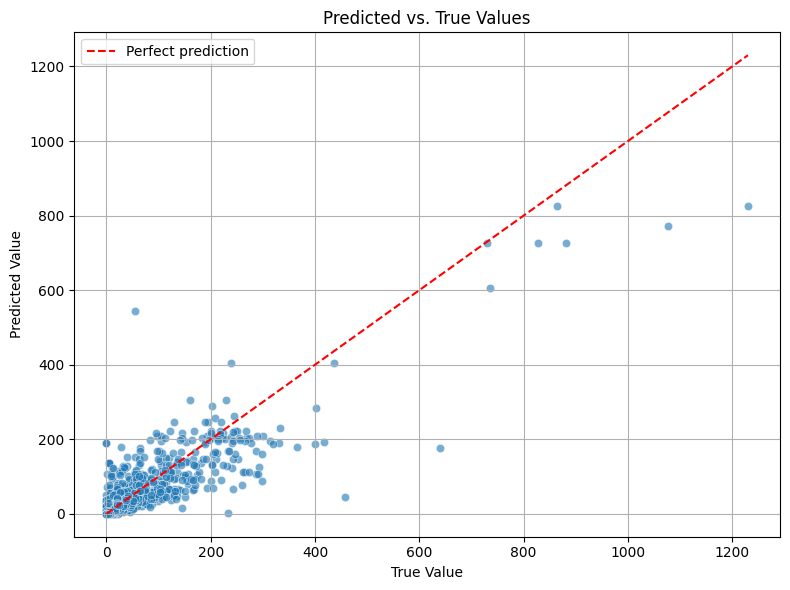

In [0]:
df_result = pd.DataFrame({"truth":truth, "prediction": prediction})
df_result.columns = ['y_true', 'y_pred']
plt.figure(figsize=(8, 6))
sns.scatterplot(x='y_true', y='y_pred', data=df_result, alpha=0.6)
plt.plot([df_result.y_true.min(), df_result.y_true.max()],
         [df_result.y_true.min(), df_result.y_true.max()],
         '--', color='red', label='Perfect prediction')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

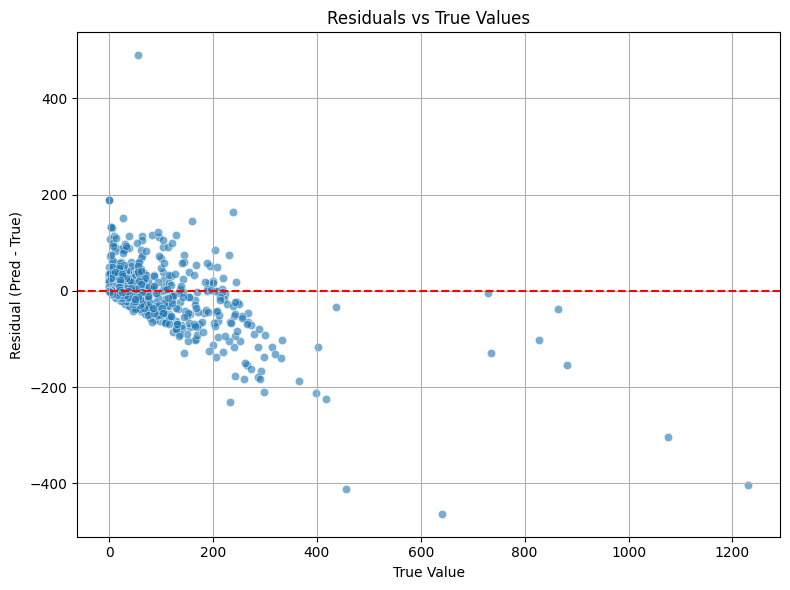

In [0]:
df_result["residual"] = df_result["y_pred"] - df_result["y_true"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="y_true", y="residual", data=df_result, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("True Value")
plt.ylabel("Residual (Pred - True)")
plt.title("Residuals vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

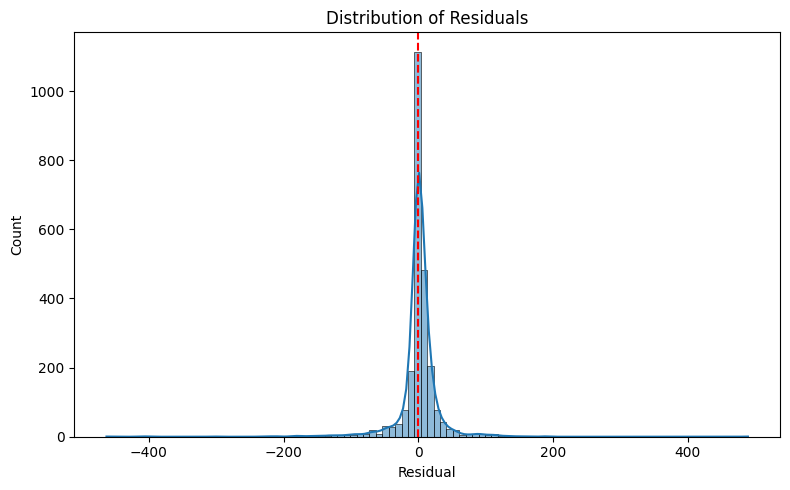

In [0]:
plt.figure(figsize=(8, 5))
sns.histplot(df_result["residual"], kde=True, bins=100)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

### Feature importance exploration

In [0]:
preproc = pipeline.named_steps["preprocessor"]
xgb_model = pipeline.named_steps["model"]
feature_names = preproc.get_feature_names_out()
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)
print(f"There are {len(importance_df)} features in total to train the model")
print('Here the top 10 most important features')
importance_df.head(10)

There are 251 features in total to train the model
Here the top 10 most important features


,feature,importance
1,numeric__discount_rank,0.144622
3,numeric__base_line_purchases,0.119374
10,categorical__INDEX_GROUP_NAME_Home,0.087409
9,categorical__INDEX_GROUP_NAME_Divided,0.071369
6,numeric__markdown,0.067007
70,categorical__DEPARTMENT_NAME_Jersey Basic,0.060315
2,numeric__sold_days,0.050058
248,categorical__PRODUCT_TYPE_NAME_Underwear bottom,0.042297
140,categorical__DEPARTMENT_NAME_Swimwear,0.030638
11,categorical__INDEX_GROUP_NAME_Ladieswear,0.023889


### Case level investigation

In [0]:
df_test = df_train.loc[y_test.index][['article', 'date', 'purchases'] + num_cols + cat_cols]
df_test['prediction'] = prediction
df_test['uplift'] = df_test['prediction']/df_test['base_line_purchases'].round(2)

In [0]:
df_test[df_test['article']==411013013][['date','markdown','price','discount_rank','purchases','uplift'] + cat_cols].sort_values(by='date')

,date,markdown,price,discount_rank,purchases,uplift,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME
718,2017-10-06,0,9.99,2,3.0,0.009820,Baby/Children,Baby basics,Tank top
719,2017-10-07,0,9.99,2,0.0,0.009820,Baby/Children,Baby basics,Tank top
720,2017-10-08,0,9.99,3,6.0,0.387302,Baby/Children,Baby basics,Tank top
5761,2017-10-09,1,9.99,4,12.0,4.526284,Baby/Children,Baby basics,Tank top
5762,2017-10-10,1,9.99,4,25.0,4.829185,Baby/Children,Baby basics,Tank top
5763,2017-10-11,1,9.99,1,0.0,0.078277,Baby/Children,Baby basics,Tank top
5764,2017-10-12,1,9.99,4,28.0,4.829185,Baby/Children,Baby basics,Tank top
5765,2017-10-13,1,9.99,4,50.0,4.829185,Baby/Children,Baby basics,Tank top


In [0]:
df_test[df_test['article']==531530001][['date','markdown','price','discount_rank','purchases','uplift'] + cat_cols].sort_values(by='date')

,date,markdown,price,discount_rank,purchases,uplift,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME
3234,2017-10-02,0,19.99,2,10.0,0.743008,Baby/Children,Trouser,Trousers
3235,2017-10-03,0,19.99,1,11.0,0.743008,Baby/Children,Trouser,Trousers
3236,2017-10-04,0,19.99,2,25.0,0.743008,Baby/Children,Trouser,Trousers
3238,2017-10-06,0,19.99,2,17.0,0.743008,Baby/Children,Trouser,Trousers
8708,2017-10-09,1,19.99,1,0.0,0.000000,Baby/Children,Trouser,Trousers
8711,2017-10-12,1,19.99,1,0.0,0.000000,Baby/Children,Trouser,Trousers
8714,2017-10-15,1,19.99,1,0.0,0.000000,Baby/Children,Trouser,Trousers
